# CLASSIFICATION OF CONTACTS IN PROTEIN STRUCTURE
### A project by Antonio Feltrin, Emma Lovato and Mattia Piazza

## Introduction
Residue Interaction Networks (RINs) are derived from protein structures based on geometrical and physico-chemical properties of amino acids.

RING is a software tool that takes a PDB file as input and returns the list of contacts (residue-residue pairs) and their types in a protein structure.

The contact types include:
- Hydrogen bonds (HBOND)
- Van der Waals interactions (VDW)
- Disulfide bridges (SSBOND)
- Salt bridges (IONIC)
- π-π stacking (PIPISTACK)
- π-cation (PICATION)
- π-hydrogen bond (PIHBOND)

## Goal
The goal of this project is to develop a software tool that predicts the RING classification of a contact based on statistical or supervised learning methods, rather than geometrical constraints. This report details the implementation and results of our approach.

## Methods
We implemented a learning approach to classify contacts in protein structures. The implementation includes features extraction, diverse models training, and evaluation.

## Importing Libraries


In [3]:
# basics/util
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import random
import joblib
import logging
import itertools

# sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    matthews_corrcoef,
    balanced_accuracy_score,
)
from scipy.stats import uniform
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer


# plot
import seaborn as sns
import matplotlib.pyplot as plt

# PCA
from sklearn.decomposition import PCA

# NNet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    InputLayer,
    Embedding,
    Flatten,
    Input,
    Concatenate,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# HiddenLayer
#import hiddenlayer as hl

## Pre-Processing
We build a large dataframe from the RING analyses of 3299 proteins. We drop the rows containing NaN values (mainly, the 'Interaction' = 'Unclassified' records) and filter out some of the features.

Each row identifies a contact, with the same 12 features for the source and target residues. The last column is the RING prediction.

resn and ss8 are categorical features, the other are numerical.

|feature| meaning|
|-------|:------|
| resn   |residue name|   
| ss8    |secondary structure state(DSSP)    |
| rsa    |relative solvent accessibility|
| up     |half sphere exposure up|
| down   |half sphere exposure down|
| phi    |phi angle|
| psi    |psi angle|
| a1     |Atchley feature 1|
| a2     |Atchley feature 2|
| a3     |Atchley feature 3|
| a4     |Atchley feature 4|
| a5     |Atchley feature 5|

In [4]:
random.seed(42)

### Dataset loading
Load the .csv file with the RING outputdataset.

In [5]:
#path_to_data = Path("../data")
drivepath = "drive/MyDrive/Structural Bio/project/features_df.csv"


df0 = pd.read_csv(drivepath)  # "df_complete.csv") path_to_data / "df_start.csv"
df0.head()

,Unnamed: 0,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,0,5yku,A,34,,I,E,0.041,23.0,10.0,...,17.0,-2.232,2.882,H,1.357,-1.453,1.477,0.113,-0.837,NaN
1,1,5yku,A,71,,G,E,0.417,13.0,11.0,...,18.0,-2.909,2.836,H,0.260,0.830,3.097,-0.838,1.512,NaN
2,2,5yku,A,51,,R,-,0.137,19.0,2.0,...,21.0,-1.629,1.721,H,0.931,-0.179,-3.005,-0.503,-1.853,HBOND
3,3,5yku,A,20,,W,-,0.013,24.0,7.0,...,22.0,-1.116,2.553,H,0.189,2.081,-1.628,0.421,-1.392,NaN
4,4,5yku,A,23,,P,-,0.037,19.0,11.0,...,6.0,-2.672,2.564,H,0.931,-0.179,-3.005,-0.503,-1.853,NaN


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
df = df0.copy()
df.dropna(inplace=True)

# Define ground truth values
yy = df["Interaction"].astype("category")
yy.head()

2     HBOND
5     HBOND
6       VDW
7       VDW
12    IONIC
Name: Interaction, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

In [8]:
# Define training features
X = df[
    [
        "s_resn",
        "s_ss8",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_resn",
        "t_ss8",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
        "Interaction",
    ]
]

X.head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
2,R,-,0.137,19.0,2.0,-2.857,2.171,1.538,-0.055,1.502,...,18.0,21.0,-1.629,1.721,0.931,-0.179,-3.005,-0.503,-1.853,HBOND
5,Q,E,0.217,17.0,6.0,-2.672,2.564,0.931,-0.179,-3.005,...,20.0,14.0,-2.009,2.471,-0.032,0.326,2.213,0.908,1.313,HBOND
6,Q,E,0.217,17.0,6.0,-2.672,2.564,0.931,-0.179,-3.005,...,20.0,14.0,-2.009,2.471,-0.032,0.326,2.213,0.908,1.313,VDW
7,F,E,0.208,11.0,21.0,-2.756,2.364,-1.006,-0.590,1.891,...,8.0,12.0,-1.204,2.372,-1.239,-0.547,2.131,0.393,0.816,VDW
12,K,E,0.707,0.0,21.0,-2.126,2.218,1.831,-0.561,0.533,...,7.0,21.0,-2.488,1.669,1.050,0.302,-3.656,-0.259,-3.242,IONIC


## Data augumentation
Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing data. By applying transformations such as rotation, scaling, cropping, flipping, and adding noise, data augmentation helps models improving accuracy on unseen data.

In [9]:
# Bonds
abundancy_bonds = X.groupby(["Interaction"]).size()
abundancy_bonds

rare_abundancy = abundancy_bonds[abundancy_bonds < 100000]
rare_abundancy

rarebonds = rare_abundancy.keys()
rarebonds

Index(['IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND'], dtype='object', name='Interaction')

Classes 1,2,3,4,5 are severely underrepresented in the dataset and the network won't fit very well. So to balance things out, we will oversample them via a custom data augmentation procedure. In order to maintain the abundancy hierarchy, we will oversample more the (relatively) more frequent among the rare classes, i.e.

|class|"oversamples" count|
|-----|:------------|
|IONIC(1)|80'000|
|PICATION(2)|60'000|
|PIHBOND(3)|40'000|
|PIPISTACK(4)|80'000|
|SSBOND(5)|40'000|

We are thus going to be adding a total of 300k records to our dataset, which we remind comprises ~1.5M records. The updated abundancy table for the rare classes should then be:

|class|updated count|
|-----|:------------|
|IONIC(1)|107'538|
|PICATION(2)|66'874|
|PIHBOND(3)|41'669|
|PIPISTACK(4)|110'117|
|SSBOND(5)|41'657|

In [10]:
# let's say "-" is undefined ("u")
ss8_dic = {
    "H": 0,  # alpha-helix
    "B": 1,  # isolated beta-bridge
    "E": 2,  # extended strand
    "G": 3,  # 3-10 helix
    "I": 4,  # pi-helix
    "T": 5,  # turn
    "S": 6,  # bend
    "C": 7,  # coil
    "-": 8,  # undefined
}

In [11]:
bonds_custom = {
    "HBOND": 0,
    "IONIC": 1,
    "PICATION": 2,
    "PIHBOND": 3,
    "PIPISTACK": 4,
    "SSBOND": 5,
    "VDW": 6,
}
numbonds = 7
ys = X["Interaction"].map(bonds_custom)
ys.head(10)

2     0
5     0
6     6
7     6
12    1
13    0
14    6
19    0
20    6
22    0
Name: Interaction, dtype: int64

In [12]:
residuenames = sorted(df["s_resn"].unique())
residuenames_dic = {
    "A": 0,  # alanine Aliphatic
    "C": 1,  # cysteine Sulfur
    "D": 2,  # aspartic acid Acidic
    "E": 3,  # glutamic acid Acidic
    "F": 4,  # phenylalanine Aromatic
    "G": 5,  # glycine Aliphatic
    "H": 6,  # histidine Basic Charged
    "I": 7,  # isoleucine Aliphatic
    "K": 8,  # lysine Basic Charged
    "L": 9,  # leucine Aliphatic
    "M": 10,  # methionine Aliphatic Sulfur
    "N": 11,  # asparagine Acidic
    "P": 12,  # proline Cyclic
    "Q": 13,  # glutamine Acidic
    "R": 14,  # arginine Basic Charged
    "S": 15,  # serine Hydroxyl
    "T": 16,  # threonine Hydroxyl
    "V": 17,  # valine Aliphatic
    "W": 18,  # tryptophan Aromatic
    "Y": 19,  # tyrosine Hydroxyl Aromatic
}

In [75]:
# Categorical features pre-processing
Xx = X.copy()
Xx["s_resn"] = Xx["s_resn"].map(residuenames_dic)
Xx["t_resn"] = Xx["t_resn"].map(residuenames_dic)
Xx["s_ss8"] = Xx["s_ss8"].map(ss8_dic)
Xx["t_ss8"] = Xx["t_ss8"].map(ss8_dic)
Xx["Interaction"] = Xx["Interaction"].map(bonds_custom)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
# Number of augumented records per class
oversamples = (
    pd.Series([20000, 15000, 10000, 20000, 10000]) * 4
).tolist()  # see table above
oversamples

[80000, 60000, 40000, 80000, 40000]

In [15]:
# Lis of columns to modify in data augumentation phase
mutacol = [
    "s_rsa",
    "s_up",
    "s_down",
    "s_phi",
    "s_psi",
    "t_rsa",
    "t_up",
    "t_down",
    "t_phi",
    "t_psi",
]
mutatidx = [index for index, value in enumerate(Xx.columns) if value in mutacol]
mutatidx  # this is the list of column indexes on which we want to perform DAUG

[2, 3, 4, 5, 6, 14, 15, 16, 17, 18]

In [16]:
# Function to modify some entries of a row
def mod_row(row, factor=10, idxs=[], extract=-1, verbose=False):
    # idxs by default are all
    if len(idxs) < 1:
        idxs = np.arange(0, row.shape[0])  # which indexes/columns can be modified?
    if extract < 0:
        extract = np.random.choice(
            len(idxs) + 1, 1
        )  # how many indexes do you want to mod? NB choice(5,1) is btw 0 and 4 included so must do 5+1 to select a 5 (all items in row)
    col_mutanda = np.sort(
        np.random.choice(idxs, size=extract, replace=False)
    )  # select randomly which columns to modify
    mrow = row.copy()
    mrow[col_mutanda] *= factor
    if verbose:
        print(f"extract = {extract}, col_mutanda = {col_mutanda}, row = {row}")

    return mrow

### Data augumentation workflow
This is the procedure we use for data augmentation, also described in the diagram below.

We start by selecting the sub-dataframe for each of the rare classes. Then we apply the mod_row function to every record in the sub-df until we reach the desired amount of augmented data. Finally, we merge the augmented rows with the original dataset.

The augmented rows are not mere copies of the already existing ones, but noisy modifications. The noise factor is conservatively set to a 1% change. We would like to corrupt as many features as possible, because too many identical copies could cause overfitting. For this purpose, we choose the following 10 numerical features: 
['s_rsa', 's_up', 's_down', 's_phi', 's_psi','t_rsa', 't_up', 't_down', 't_phi', 't_psi']

The other 5(10) numerical columns are the Atchley features, which are specific to each aminoacid. Thus, changing them would train the model on a non-physical example. The underlying assumption is that the features selected above can vary according to the position of the residue in the chain and to its neighbors. Lastly, the categorical features do not seem so easy to "tweak", so we leave them as they are.

IDEA:
- do for every rare class:

  - create Xdumbo = X where interaction == class

  - create aug_df = []

  - do for every oversample in rare class:

      - take a row, mod it, append it to aug_df

  - append augmented class (aug_df) to the whole dataset

In [17]:
# Reminder
for i in zip(rarebonds, rare_abundancy, oversamples):
    print(i)

('IONIC', 27538, 80000)
('PICATION', 6874, 60000)
('PIHBOND', 1669, 40000)
('PIPISTACK', 30117, 80000)
('SSBOND', 1657, 40000)


### Data augumentation processing

In [18]:
# Data Augumentation
DAUG = pd.DataFrame([])
DAUG_factor = 1.01  # conservative tweak

for jj in range(5):
    print(oversamples[jj], rarebonds[jj], rare_abundancy[jj])
    Xdumbo = Xx[Xx["Interaction"] == jj + 1]
    aug_rows = np.zeros(shape=(oversamples[jj], Xdumbo.shape[1]))  # append is slow
    print(Xdumbo.shape)

    for ii in range(oversamples[jj]):
        pp = ii % rare_abundancy[jj]  # this way, if 1669 < 10000, we restart
        roww = np.array(Xdumbo.iloc[pp])  # take a row
        aug_rows[ii] = mod_row(
            roww, factor=DAUG_factor, idxs=mutatidx, verbose=False
        )  # mod it

    aug_df = pd.DataFrame(aug_rows, columns=Xx.columns)
    DAUG = pd.concat([DAUG, aug_df], ignore_index=True)

80000 IONIC 27538
(27538, 25)
60000 PICATION 6874
(6874, 25)
40000 PIHBOND 1669
(1669, 25)
80000 PIPISTACK 30117
(30117, 25)
40000 SSBOND 1657
(1657, 25)


In [19]:
# Dataframe
DAUG.head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,8.0,2.0,0.71407,0.00,21.00,-2.14726,2.24018,1.831,-0.561,0.533,...,7.07,21.00,-2.48800,1.66900,1.050,0.302,-3.656,-0.259,-3.242,1.0
1,14.0,6.0,0.04444,17.17,11.11,-1.44127,-0.42824,1.538,-0.055,1.502,...,6.06,12.12,-1.80790,1.61398,1.050,0.302,-3.656,-0.259,-3.242,1.0
2,8.0,0.0,0.54100,4.00,17.00,-1.09787,-0.64034,1.831,-0.561,0.533,...,7.07,14.14,-0.91100,-0.59400,1.357,-1.453,1.477,0.113,-0.837,1.0
3,2.0,0.0,0.00000,14.14,21.21,-1.09484,-0.87062,1.050,0.302,-3.656,...,14.14,4.04,-0.94738,2.42602,1.538,-0.055,1.502,0.440,2.897,1.0
4,3.0,0.0,0.44238,7.00,14.00,-1.16700,-0.73200,1.357,-1.453,1.477,...,14.14,9.09,-1.08777,-0.73427,1.831,-0.561,0.533,-0.277,1.648,1.0


In [20]:
Xx[Xx["Interaction"] == 1].head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
12,8,2,0.707,0.0,21.0,-2.126,2.218,1.831,-0.561,0.533,...,7.0,21.0,-2.488,1.669,1.050,0.302,-3.656,-0.259,-3.242,1
168,14,6,0.044,17.0,11.0,-1.427,-0.424,1.538,-0.055,1.502,...,6.0,12.0,-1.790,1.598,1.050,0.302,-3.656,-0.259,-3.242,1
212,8,0,0.541,4.0,17.0,-1.087,-0.634,1.831,-0.561,0.533,...,7.0,14.0,-0.911,-0.594,1.357,-1.453,1.477,0.113,-0.837,1
334,2,0,0.000,14.0,21.0,-1.084,-0.862,1.050,0.302,-3.656,...,14.0,4.0,-0.938,2.402,1.538,-0.055,1.502,0.440,2.897,1
397,3,0,0.438,7.0,14.0,-1.167,-0.732,1.357,-1.453,1.477,...,14.0,9.0,-1.077,-0.727,1.831,-0.561,0.533,-0.277,1.648,1


As we can see above, the DAUG takes rows from the original dataframe and tweaks them. Only some specifics columns are untouched. (it would not make any sense, for example, to change the Atchley features or the amino acid species).

Below is a more compact view of the modified dataframe, with just the columns of interest on display.

In [21]:
DAUG[mutacol].head()

,s_rsa,s_up,s_down,s_phi,s_psi,t_rsa,t_up,t_down,t_phi,t_psi
0,0.71407,0.00,21.00,-2.14726,2.24018,0.42300,7.07,21.00,-2.48800,1.66900
1,0.04444,17.17,11.11,-1.44127,-0.42824,0.42117,6.06,12.12,-1.80790,1.61398
2,0.54100,4.00,17.00,-1.09787,-0.64034,0.39592,7.07,14.14,-0.91100,-0.59400
3,0.00000,14.14,21.21,-1.09484,-0.87062,0.18281,14.14,4.04,-0.94738,2.42602
4,0.44238,7.00,14.00,-1.16700,-0.73200,0.40500,14.14,9.09,-1.08777,-0.73427


In [22]:
# Last check size
print(Xx.shape)
print(DAUG.shape)

(1471380, 25)
(300000, 25)


Finally, the merge with the "mother dataframe".

In [23]:
Xx = pd.concat([Xx, DAUG], ignore_index=True)

In [24]:
yy = Xx["Interaction"]
yy.shape

(1771380,)

In [25]:
# Split the dataset to define training and testing examples
Xx_train, Xx_test, yy_train, yy_test = train_test_split(
    Xx, yy, test_size=0.1, random_state=42
)

yy_train = to_categorical(yy_train, num_classes=numbonds)
yy_test = to_categorical(yy_test, num_classes=numbonds)
yy_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Random Forest
The Random Forest classifier was chosen for its robustness and ability to handle large datasets with high dimensionality.

For classification tasks, it outputs the class that is the mode of the classes output by individual trees. The underlying principle involves two main steps:

- Bootstrap Aggregating (Bagging): Random subsets of the training data are used to train each tree. This helps in reducing the variance of the model without increasing the bias.
- Random Feature Selection: At each split in the tree, a random subset of features is considered, ensuring that the trees are de-correlated.

### Model implementation
We implemented the Random Forest algorithm, an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification tasks.

We create the model and then the performance of the model is evaluated by calculating the number of mislabeled points and the overall accuracy.


In [27]:
# Train the RF model
forest = RandomForestClassifier().fit(Xx_train, yy_train)
y_pred = forest.predict(Xx_test)

# Performance of the model
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (Xx_test.shape[0], (yy_test != y_pred).sum())
)

accuracy = accuracy_score(yy_test, y_pred)
print("Accuracy:", accuracy)

Number of mislabeled points out of a total 177138 points : 0
Accuracy: 1.0


### Results
The trained Random Forest model is evaluated on the test set.

The performance metrics indicate the effectiveness of the model. The number of mislabeled points out of the total test points is printed, followed by the accuracy of the model. The accuracy achieved demonstrates the model's capability in classifying the contact types in the protein structures.

Achieving an accuracy of 1 (or 100%) on the training dataset when using a Random Forest model is often a strong indicator of overfitting. 

Overfitting occurs when the model learns the training data too well, capturing noise and details that do not generalize to new, unseen data. As a result, while the model performs exceptionally on the training set, its performance on test data or real-world scenarios may significantly drop. To mitigate overfitting, techniques such as cross-validation, pruning, and tuning model hyperparameters should be employed.


## Logistic Regression

### Model training
We trained a Logistic Regression model for multi-class classification. The target variable is the interaction type, and the features are the various structural and physico-chemical properties of the residues involved in the contact.

In [28]:
#path_to_data = Path("../data")

#df_complete = pd.read_csv(path_to_data / "df_start.csv")
#df_complete.dropna(inplace=True)
df_complete = df.copy()

y = df_complete["Interaction"].astype("category")
# Define training features
X = df_complete[
    [
        "s_ss8",
        "s_ss3",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_ss8",
        "t_ss3",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset to define training and testing examples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [29]:
# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize
        ("logreg", LogisticRegression(random_state=42)),
    ]
)

# Define the hyperparameter grid
param_dist = {
    "logreg__C": uniform(loc=0.1, scale=5),  # Reduce the range of C values
    "logreg__solver": ["liblinear"],
    "logreg__penalty": ["l2"],  # Only one penalty
    "logreg__max_iter": [100],  # Only one value for max_iter
}

# Define the cross-validation strategy:
# Use cross-validation to select the best model hyperparameters.
cv_strategy = StratifiedKFold(
    n_splits=3, shuffle=True, random_state=42
)  # Use fewer folds

# Perform hyperparameter search with HalvingRandomSearchCV
random_search = HalvingRandomSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_candidates=30,  # Limit the number of candidates
    factor=3,
    resource="n_samples",
    max_resources="auto",
    min_resources=50,  # Increase min_resources to start with more samples
    cv=cv_strategy,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Fit the model:
# Training the Logistic Regression model on the training dataset.
random_search.fit(X_train, y_train)

# Best model
best_logreg = random_search.best_estimator_

# Results
print(f"Best score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 50
max_resources_: 1324242
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 50
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


----------
iter: 1
n_candidates: 10
n_resources: 150
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 4
n_resources: 450
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 1350
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.5370370370370371
Best parameters: {'logreg__C': 0.3904180608409973, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


### Evaluation
The model is evaluated using the following metrics to assess the model performance:

- Cross-validation Accuracy: The average accuracy obtained across different splits of the data during cross-validation
- Accuracy: The ratio of correctly predicted instances to the total instances.
- Matthews Correlation Coefficient (MCC): A correlation coefficient between the observed and predicted binary classifications, considering true and false positives and negatives.
- Balanced Accuracy: he average of recall obtained on each class
- ROC-AUC: A metric that measures the area under the ROC curve, which plots the true positive rate against the false positive rate for different threshold values.
- Classification Report:
    1. Precision: The ratio of true positive predictions to the total predicted positives for each class. It indicates how many of the predicted positive instances are actually correct.
    2. Recall: The ratio of true positive predictions to the total actual positives for each class. It measures how many of the actual positive instances are correctly predicted.
    3. F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics.
    4. Support: The number of actual occurrences of each class in the test set

In [30]:
# Cross-validation
cv = StratifiedKFold(n_splits=3)
cv_scores = cross_val_score(
    best_logreg, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
)  # Parallelization

print(f"Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Prediction
y_pred = best_logreg.predict(X_test)

# Evaluation metrichs
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(
    pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class="ovo"
)

print(f"Accuracy: {accuracy:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation Accuracy: 0.57 ± 0.00
Accuracy: 0.56
Matthews Correlation Coefficient: 0.09
Balanced Accuracy: 0.24
ROC-AUC: 0.54
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       HBOND       0.57      0.96      0.72     82033
       IONIC       0.00      0.00      0.00      2754
    PICATION       0.00      0.00      0.00       687
     PIHBOND       0.00      0.00      0.00       167
   PIPISTACK       0.39      0.27      0.32      3012
      SSBOND       0.47      0.39      0.43       166
         VDW       0.45      0.06      0.11     58319

    accuracy                           0.56    147138
   macro avg       0.27      0.24      0.22    147138
weighted avg       0.51      0.56      0.45    147138



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We used then the CONFUSION MATRIX, that is a table used to evaluate the performance of a classification model. It provides a comprehensive insight into how well the model is making predictions by showing the actual versus predicted classifications.

The confusion matrix consists of four components:
- True Positives (TP): The number of instances correctly predicted as positive.
- True Negatives (TN): The number of instances correctly predicted as negative.
- False Positives (FP): The number of instances incorrectly predicted as positive (Type I error).
- False Negatives (FN): The number of instances incorrectly predicted as negative (Type II error).

For multiclass classification, the confusion matrix is an n×n matrix where n is the number of classes. Each cell (i,j) in the matrix represents the number of observations that are actually in class i but predicted to be in class j.


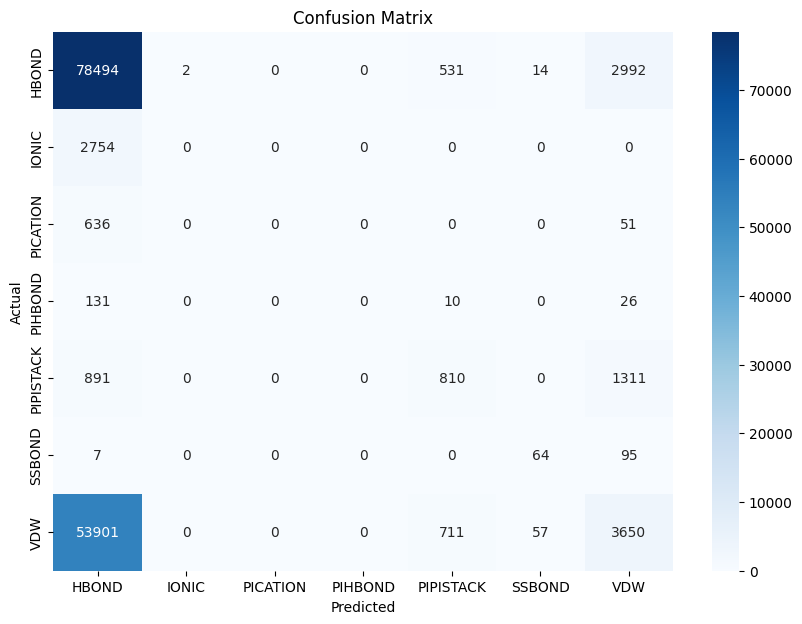

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y),
    yticklabels=np.unique(y),
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a classification model.
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

The area under the ROC curve (AUC) provides a single measure of a classifier's performance across all classification thresholds.

Micro-average ROC: Aggregates the contributions of all classes to calculate a single ROC curve. It weights the results based on the frequency of the classes and is influenced by the most frequent class.

Macro-average ROC: Calculates a separate ROC curve for each class and then averages them. It treats each class with equal importance, regardless of their frequency, and weights each class equally.

When to use which?
- Micro-average ROC: when you want an overall measure of your model's performance that takes class distribution into account. It is suitable for datasets with imbalanced classes.
- Macro-average ROC: when you want to evaluate the average performance of your model across all classes without the class distribution affecting the result. It is suitable for datasets with balanced classes or when each class is equally important.

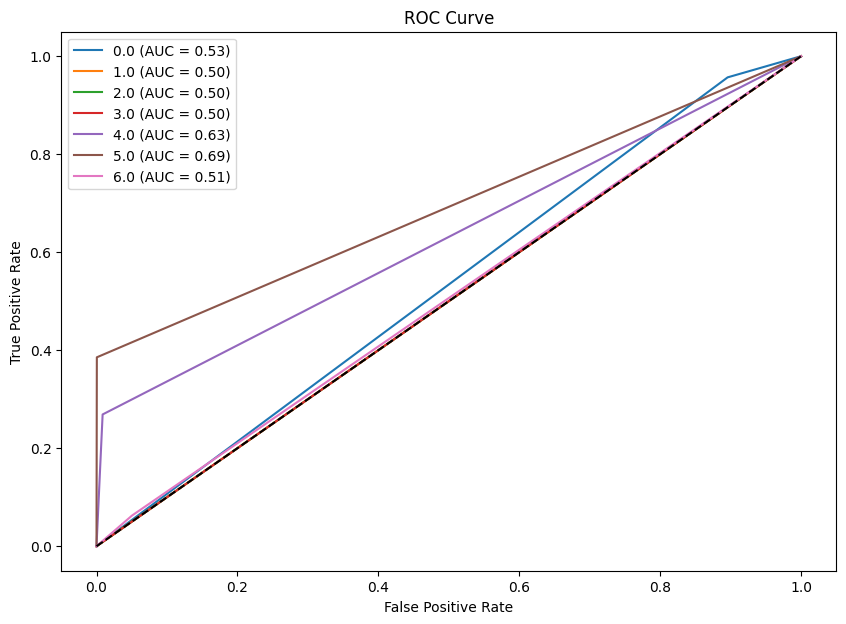

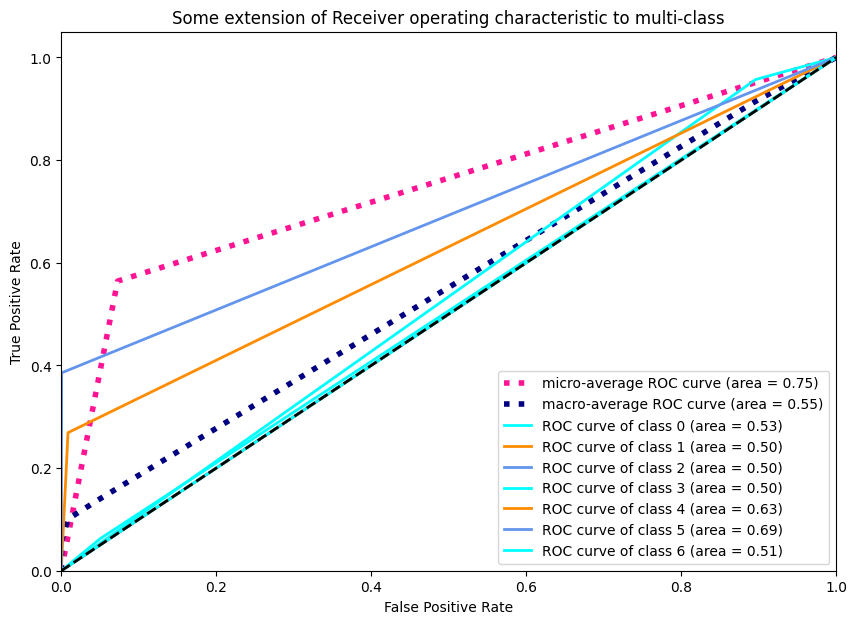

In [32]:
# ROC Curve

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y))

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(yy)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_binarized.ravel(), y_pred_binarized.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = itertools.cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})" "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multi-class")
plt.legend(loc="lower right")
plt.show()

### Results
- Cross-validation accuracy: It provides an estimate of how the model is expected to perform on unseen data. A value of 0.57 ± 0.00 indicates that the model has a consistent accuracy of 57% across the three folds.
- Accuracy: Accuracy measures how often the model correctly predicts the classes. An accuracy of 0.57 means the model correctly predicts 57% of the instances in the test set.
- MCC: MCC ranges from -1 to 1, where 1 indicates perfect prediction, 0 no better than random prediction, and -1 indicates total disagreement. An MCC of 0.10 suggests a low positive correlation between the predictions and the actual classes.
- Balanced Accuracy: This metric adjusts for imbalanced class distribution by considering the recall of each class. A balanced accuracy of 0.27 indicates poor performance, especially for less frequent classes.
- ROC-AUC: For multiclass classification, it is computed using the one-vs-one (ovo) method. A value of 0.54 indicates that the model's ability to distinguish between classes is only slightly better than random guessing.
- Classification report summary:
    1. HBOND: The model performs reasonably well with a precision of 0.57 and a recall of 0.96.
    2. IONIC, PICATION, PIHBOND: The model struggles with these classes, achieving very low precision and recall, indicating poor prediction capabilities.
    3. PIPISTACK: Shows moderate performance with a precision of 0.41 and a recall of 0.27.
    4. SSBOND: Has a relatively better performance with a precision of 0.54 and a recall of 0.61.
    5. VDW: The model performs poorly with a precision of 0.47 and a recall of 0.07.
    6. Overall Accuracy: The model's overall accuracy is 0.57, indicating that it correctly predicts 57% of the instances.
    7. Macro Average: Averages precision, recall, and F1-score across all classes, treating all classes equally. The macro averages are 0.34 (precision), 0.27 (recall), and 0.25 (F1-score).
    8. Weighted Average: Averages precision, recall, and F1-score across all classes, weighted by the number of instances of each class. The weighted averages are 0.52 (precision), 0.57 (recall), and 0.45 (F1-score).
- Confusion matrix describes that there are:
    1. Class Imbalance: The model shows varying performance across different classes, with the majority classes such as HBOND and VDW having higher accuracy. 
    This suggests that the model might be biased towards these majority classes.
    2. VDW Class: There are significant misclassifications into the VDW class, particularly from HBOND and PIPISTACK. This indicates that the features distinguishing these classes might be similar, leading to confusion in the model.
    3. Minority Classes: Classes like PICATION and PIHBOND have very low correct prediction rates, highlighting the model's difficulty in accurately identifying these less frequent classes.
    4. General Accuracy: While the model performs well for the majority classes, the lower performance for minority classes suggests a need for improved handling of class imbalance, potentially through techniques like oversampling, undersampling, or using different evaluation metrics.
- ROC curve and AUC: 
    1. Class Imbalance: The model does not handle class imbalance very well, as indicated by the high micro-average AUC. 
    2. High Performance for Major Classes: Classes like HBOND and IONIC show excellent ROC curves with AUC values close to 1.0, indicating high precision and recall for these classes.
    3. Low Performance for Minor Classes: Classes such as PIPISTACK and SSBOND exhibit moderate performance. This highlights areas where the model could be improved, particularly in distinguishing these classes from others.
    4. Model Improvement Areas: The moderate AUC for certain classes suggests that the model could benefit from additional tuning or feature engineering to improve its discriminative ability for these specific classes.

## Neural Network

### Structure of the Neural Network
For our project, we implemented a neural network using the TensorFlow/Keras framework.

The neural network is composed of the following layers:
- Input Layer: Receives the feature values extracted from protein residues.
- Hidden Layers: We used two fully connected hidden layers with ReLU (Rectified Linear Unit) activation functions. The hidden layers allow the network to learn complex representations of the input data.
- Output Layer: A single fully connected layer with a softmax activation function to classify the contacts into one of the predefined categories (e.g., HBOND, VDW, etc.).

### Data pre-processing and preparation for Neural Network
Before training the neural network, we convert the target labels (contact types) into a format suitable for classification tasks.

The data we possess contains both numerical and categorical features, so it makes sense to encode them in different ways. Every numerical feature will be fed to the neural network as it is, so there will be one input neuron for each of them. Conversely, we want to remark the importance of the categorical variables res_n and ss8, i.e. the residue name and its secondary structure role as provided by DSSP.

Some types of bonds are exclusive to specific side chains (e.g. all the SSBOND contacts are between Cysteines). We will use one-hot encoding to preserve these properties, if possible.

The OHdata_num function tranforms our 24-features dataset into a 78-features one. This is done by converting the 4 categorical features into their corresponding OH-encoding (20-dimensional for s_resn and t_resn, 9-dimensional for s_ss8 and s_ss8). This dataset is then fed to the network.

In [33]:
# One-Hot encoder
def OHdata_num(df, numcols=None):
    encoder1 = OneHotEncoder(
        categories=[list(np.arange(0, 20)), list(np.arange(0, 20))], sparse_output=False
    )
    encoder2 = OneHotEncoder(
        categories=[list(np.arange(0, 9)), list(np.arange(0, 9))], sparse_output=False
    )

    features1 = encoder1.fit_transform(df[["s_resn", "t_resn"]])
    features2 = encoder2.fit_transform(df[["s_ss8", "t_ss8"]])

    if numcols:
        encoded_features = np.hstack([df[numcols], features1, features2])
    else:
        encoded_features = np.hstack([features1, features2])

    return encoded_features

In [34]:
numerical_cols_long = [
    "s_rsa",
    "s_up",
    "s_down",
    "s_phi",
    "s_psi",
    "s_a1",
    "s_a2",
    "s_a3",
    "s_a4",
    "s_a5",
    "t_rsa",
    "t_up",
    "t_down",
    "t_phi",
    "t_psi",
    "t_a1",
    "t_a2",
    "t_a3",
    "t_a4",
    "t_a5",
]
# copied from above

print(f"Before One-Hot: \n\nXx_train -> {Xx_train.shape}\nXx_test -> {Xx_test.shape}\n")

DAUGtrain = OHdata_num(Xx_train, numerical_cols_long)
DAUGtest = OHdata_num(Xx_test, numerical_cols_long)

print(f"\nAfter One-Hot: \n\nXx_train -> {DAUGtrain.shape}\nXx_test -> {DAUGtest.shape}")

Before One-Hot: 

Xx_train -> (1594242, 25)
Xx_test -> (177138, 25)


After One-Hot: 

Xx_train -> (1594242, 78)
Xx_test -> (177138, 78)


### NN model definition
We define a neural network model that consists of an input layer, three hidden layers with ReLU activation and dropout for regularization, and an output layer with softmax activation for multi-class classification. We compile the model with the Adam optimizer and categorical cross-entropy loss. The model will be trained to predict the number of interaction types numbonds.

In [35]:
input_neurons = DAUGtrain.shape[1]
hidden_dim = [256, 128]  # [256, 128, 64]

modelD = Sequential()
modelD.add(InputLayer(input_shape=(input_neurons,)))  # Input layer
for n_units in hidden_dim:
    modelD.add(Dense(n_units, activation="relu"))
    #modelD.add(Dropout(0.5))

modelD.add(
    Dense(numbonds, activation="softmax")
)  # numbonds output neurons for n interaction types

optimus = Adam()  # SGD(learning_rate=0.01)
modelD.compile(loss="categorical_crossentropy", optimizer=optimus, metrics=["accuracy"])

modelD.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               20224     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 54023 (211.03 KB)
Trainable params: 54023 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model training and testing
We use Cross-Validation for training our model, this helps to ensure a reliable performance evaluation. For each fold, the model is trained and then validated. Every cycle plots and saves the accuracies reached each epoch for future investigation.

In [36]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

batch_size = 1024  # 250
epoch = 10  # 5
fold_no = 1

history = []

for train_index, val_index in kf.split(DAUGtrain):
    X_tra, X_v = DAUGtrain[train_index], DAUGtrain[val_index]
    y_tra, y_v = yy_train[train_index], yy_train[val_index]

    print(f"Training fold {fold_no}...")
    his = modelD.fit(
        X_tra,
        y_tra,
        epochs=epoch,
        batch_size=batch_size,
        verbose=1,
        validation_data=(X_v, y_v),
    )

    history.append(his)
    fold_no += 1

Training fold 1...
Epoch 1/10
1298/1298 [==============================] - 21s 15ms/step - loss: 0.8051 - accuracy: 0.5915 - val_loss: 0.7559 - val_accuracy: 0.6070
Epoch 2/10
1298/1298 [==============================] - 20s 16ms/step - loss: 0.7501 - accuracy: 0.6117 - val_loss: 0.7471 - val_accuracy: 0.6168
Epoch 3/10
1298/1298 [==============================] - 17s 13ms/step - loss: 0.7371 - accuracy: 0.6194 - val_loss: 0.7387 - val_accuracy: 0.6140
Epoch 4/10
1298/1298 [==============================] - 18s 14ms/step - loss: 0.7278 - accuracy: 0.6242 - val_loss: 0.7264 - val_accuracy: 0.6241
Epoch 5/10
1298/1298 [==============================] - 18s 14ms/step - loss: 0.7199 - accuracy: 0.6279 - val_loss: 0.7179 - val_accuracy: 0.6296
Epoch 6/10
1298/1298 [==============================] - 18s 14ms/step - loss: 0.7130 - accuracy: 0.6312 - val_loss: 0.7145 - val_accuracy: 0.6299
Epoch 7/10
1298/1298 [==============================] - 18s 14ms/step - loss: 0.7077 - accuracy: 0.6338 -

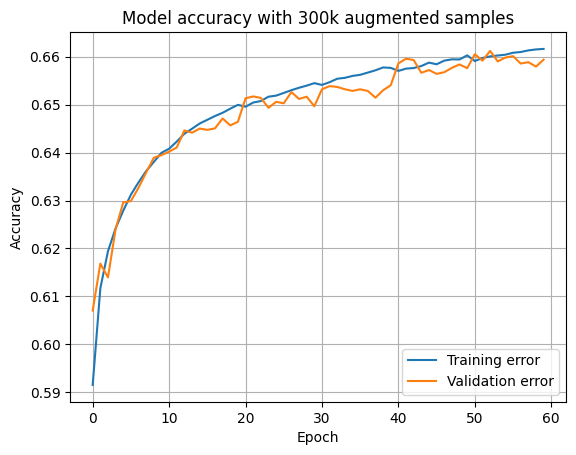

In [39]:
tr_err = []
val_err = []
for his in history:
    tr_err.append(his.history["accuracy"])
    val_err.append(his.history["val_accuracy"])
tr_err = np.reshape(tr_err, (-1,))
val_err = np.reshape(val_err, (-1,))

# Plot
plt.plot(tr_err)
plt.plot(val_err)
plt.title(f"Model accuracy with {int(sum(oversamples)/1000)}k augmented samples")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training error", "Validation error"], loc="lower right")
plt.grid()
plt.show()

In [90]:
# Confusion matrix
y_pred_probs = modelD.predict(DAUGtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(yy_test, axis=1)
cmdaug = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cmdaug)

tp = sum([cmdaug[i,i] for i in range(len(cmdaug))])
tt = sum([sum(cmdaug[i]) for i in range(len(cmdaug)) ])
print(f"test set accuracy = {np.round(tp/tt,4)*100}%")

5536/5536 [==============================] - 12s 2ms/step
Confusion Matrix:
 [[65805  4298   663   204  1166    24  9911]
 [ 1583  9230     0     0     0     0    60]
 [  158     0  6196   248     0     0    75]
 [    1     0    86  4084     8     0     1]
 [    6     0     0   127 11031     0     6]
 [    3     0     0     0     0  4111     5]
 [37071  2562   847   276  1662   119 15511]]
test set accuracy = 65.47%


In [99]:
sum(cm[5])

134

In [101]:
bonds_list = ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']
for i in range(7):
  print(f"Accuracy on the test set for class {bonds_list[i]} = {np.round(cmdaug[i,i]/( sum(cmdaug[i]) + sum(cmdaug[:,i]) - cmdaug[i,i] )*100,2)}%")


Accuracy on the test set for class HBOND = 54.43%
Accuracy on the test set for class IONIC = 52.05%
Accuracy on the test set for class PICATION = 74.89%
Accuracy on the test set for class PIHBOND = 81.11%
Accuracy on the test set for class PIPISTACK = 78.76%
Accuracy on the test set for class SSBOND = 96.46%
Accuracy on the test set for class VDW = 22.77%


<Axes: >

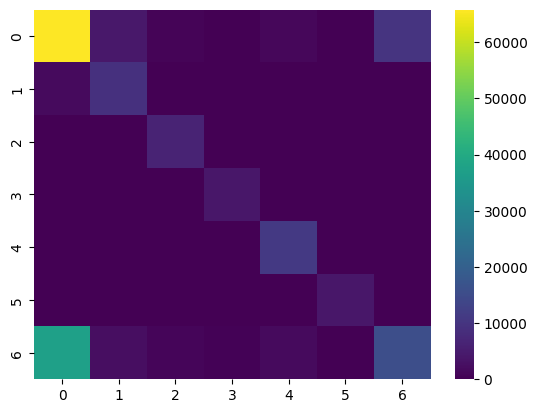

In [41]:
# Heatmap
sns.heatmap(cmdaug, cmap="viridis")

### Test on non-augmented dataset

In [82]:
X2 = df_complete[
    [
        "s_resn",
        "s_ss8",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_resn",
        "t_ss8",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
        "Interaction",
    ]
]

X2["s_resn"] = X2["s_resn"].map(residuenames_dic)
X2["t_resn"] = X2["t_resn"].map(residuenames_dic)
X2["s_ss8"] = X2["s_ss8"].map(ss8_dic)
X2["t_ss8"] = X2["t_ss8"].map(ss8_dic)
X2["Interaction"] = X2["Interaction"].map(bonds_custom)

<ipython-input-82-46dd908b76bd>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2["s_resn"] = X2["s_resn"].map(residuenames_dic)
<ipython-input-82-46dd908b76bd>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2["t_resn"] = X2["t_resn"].map(residuenames_dic)
<ipython-input-82-46dd908b76bd>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [83]:
X2oh = OHdata_num(X2,numerical_cols_long)

In [84]:
X2_test = X2oh[:140000]
y2 = X2["Interaction"]
y2_test = y2[:140000]
y2_test = to_categorical(y2_test, num_classes = numbonds)

In [88]:
# X_ftest y_test2
y_pred_probs = modelD.predict(X2_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y2_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

4375/4375 [==============================] - 17s 4ms/step
Confusion Matrix:
 [[61739  3941   572   183  1131    31  9045]
 [  296  2225     1     0     0     0    12]
 [   19     0   652    37     0     0     3]
 [    0     0     3   203     0     0     0]
 [    0     0     0    33  3265     0     0]
 [    0     0     0     0     0   134     0]
 [35368  2410   768   290  1668   105 15866]]


<Axes: >

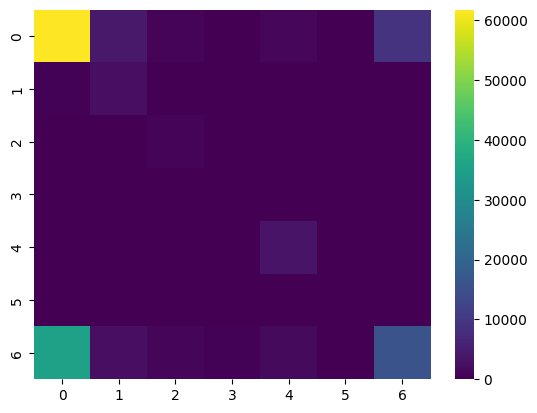

In [89]:
# Heatmap
sns.heatmap(cm, cmap="viridis")

In [92]:
tp = sum([cm[i,i] for i in range(len(cm))])
tt = sum([sum(cm[i]) for i in range(len(cm)) ])
print(f"test set accuracy = {np.round(tp/tt,4)*100}%")

test set accuracy = 60.06%


In [100]:
for i in range(7):
  print(f"Accuracy on the non-augmented test set for class {bonds_list[i]} = {np.round(cm[i,i]/( sum(cm[i]) + sum(cm[:,i]) - cm[i,i] ) *100,2)}%")

Accuracy on the non-augmented test set for class HBOND = 54.96%
Accuracy on the non-augmented test set for class IONIC = 25.04%
Accuracy on the non-augmented test set for class PICATION = 31.73%
Accuracy on the non-augmented test set for class PIHBOND = 27.1%
Accuracy on the non-augmented test set for class PIPISTACK = 53.55%
Accuracy on the non-augmented test set for class SSBOND = 49.63%
Accuracy on the non-augmented test set for class VDW = 24.21%


### Results

As expected, we find better results using the augmented dataset. By examining the heatmaps, we can see that the main diagonal is more distinct. This result is supported by the heatmaps: the model trained with augmented data highlights the diagonal of the map clearly, while the model trained on the non-augmented dataset produces a poor map that primarily focuses on just the first class.

## Conclusion

We approached the problem using three different models:

* Random Forest
* Logistic Regression
* Neural Network

After a thorough analysis, our findings indicate that the Random Forest model performs the best. The Neural Network follows, reaching a peak accuracy of 66%, while Logistic Regression lag behind, with an accuracy of 57%.

The Random Forest model's superior performance can be attributed to its ability to handle complex interactions between features and its robustness to overfitting, especially given the nature of our dataset. The Neural Network, despite its powerful capabilities, may require further tuning and potentially more data to surpass the performance of Random Forest. Logistic Regression, while simpler and more interpretable, struggled with the complexity of the classification task (it was also trained on non-augmented data).

In conclusion, for our specific problem, Random Forest stands out as the most effective model. However, further improvements could potentially be made by exploring more sophisticated neural network architectures or fine-tuning existing models. Data augmentation proved to be a valuable technique, enhancing the overall performance and accuracy of the models.

## References
- RING Software: https://ring.biocomputingup.it/
- PDB: https://www.rcsb.org/
- BioPython: https://biopython.org/